In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import warnings
warnings.filterwarnings('ignore')

In [2]:
# import data
names = ['streams', 'acousticness', 'danceability', 'energy', 'loudness', 'tempo', 'valence']
global_data  = pd.read_csv('./data/global_selected.csv',header=None, names=names)
finland_data = pd.read_csv('./data/finland_selected.csv',header=None, names=names)
sweden_data  = pd.read_csv('./data/sweden_selected.csv',header=None, names=names)

# __Appendix 2__ | Exploratory Data Analysis
We will use consistent color coding throughout this notebook to differentiate between data sets based on geography:
* Global : green
* Finland : blue
* Sweden : yellow

In [3]:
geo_labels = ['Global', 'Finland', 'Sweden'] 
tri_palette = ['#669900', '#0099ff', '#ffbd00']

### __Correlation matrices with color coding__

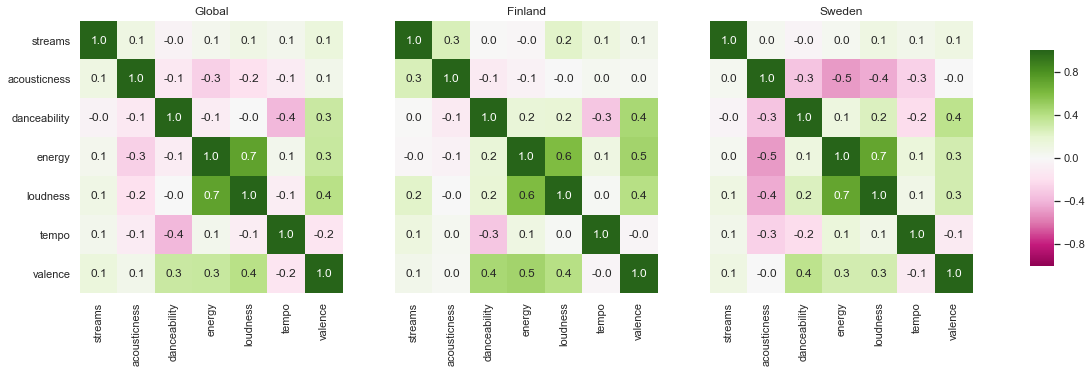

In [12]:
fig, axs = plt.subplots(1, 3, sharex=True, sharey=True)
cbar_ax = fig.add_axes([.95, .2, .02, .6])
dfs = [global_data.corr(), finland_data.corr(), sweden_data.corr()]
sns.set(rc={'figure.figsize':(14,4)})

for i, ax in enumerate(axs.flat):
    ax.set_title(geo_labels[i])
    sns.heatmap(dfs[i], ax=ax,
                cbar=i == 0,
                vmin=-1.0, vmax=1.0,
                center=0.0,
                cmap='PiYG',
                cbar_ax=None if i else cbar_ax,
                annot=True,
                fmt='.1f')

### __Global data__

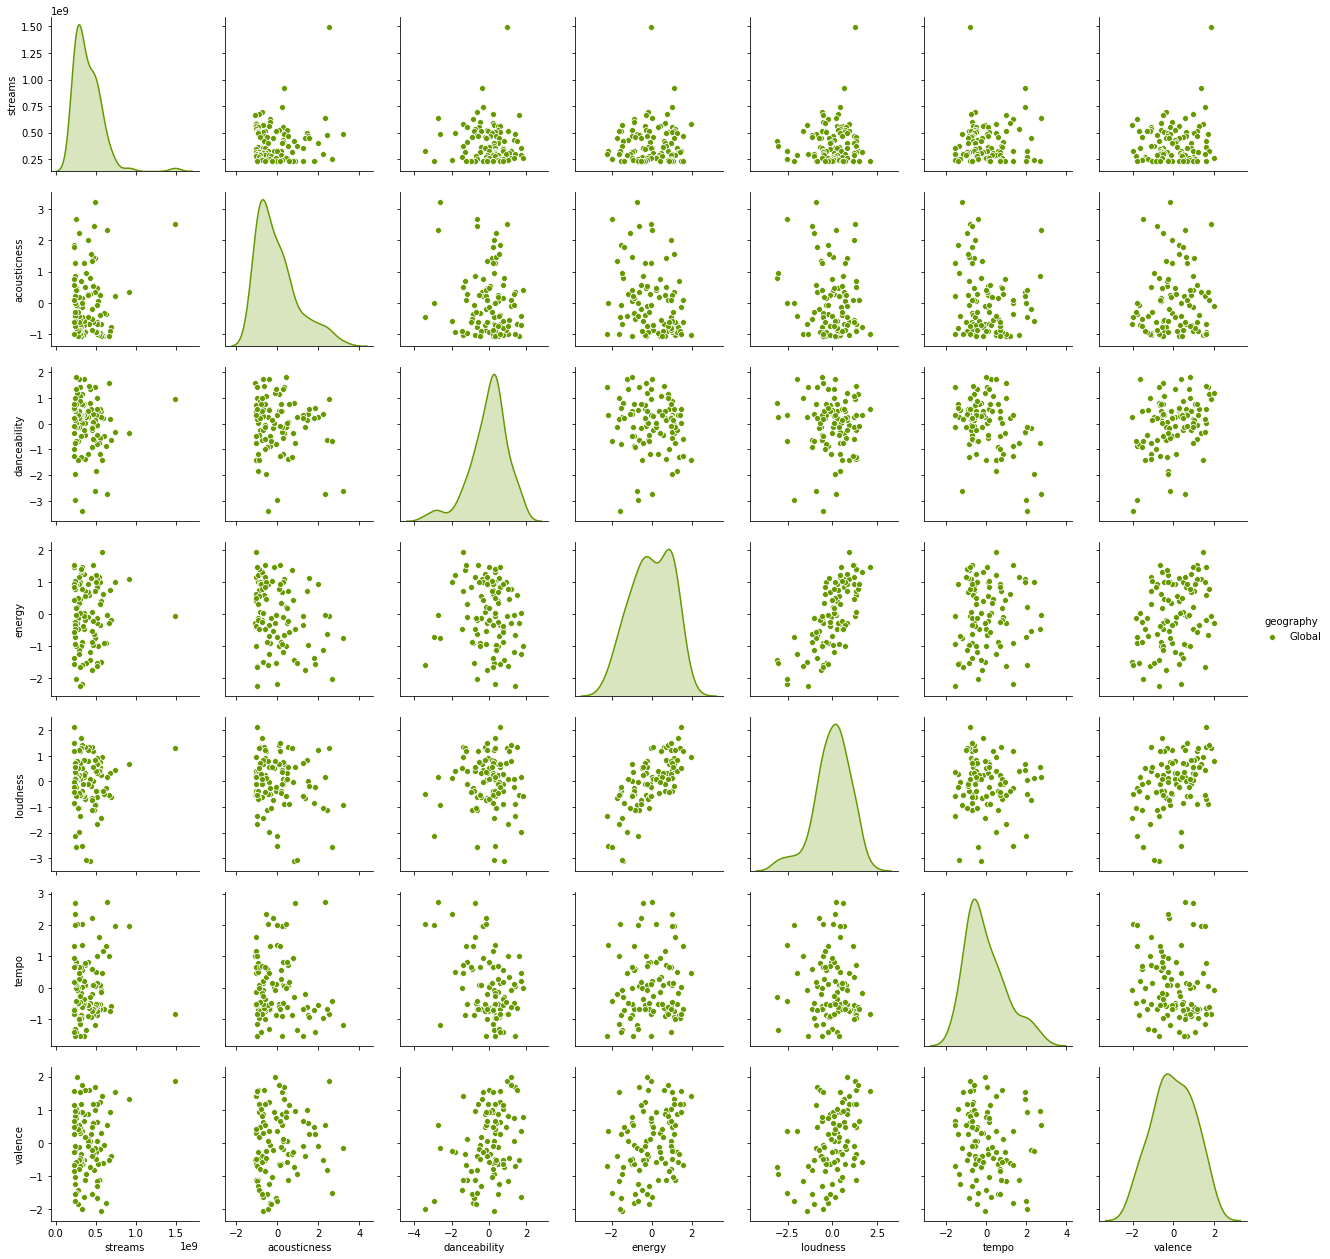

In [4]:
select = 'geography'
f1, f2, f3 = global_data, finland_data, sweden_data
f1[select], f2[select], f3[select] = geo_labels[0], geo_labels[1], geo_labels[2]
df = pd.concat([f1,f2,f3],axis=0)

sns.pairplot(f1, palette=tri_palette, hue=select)

### __Finnish data__

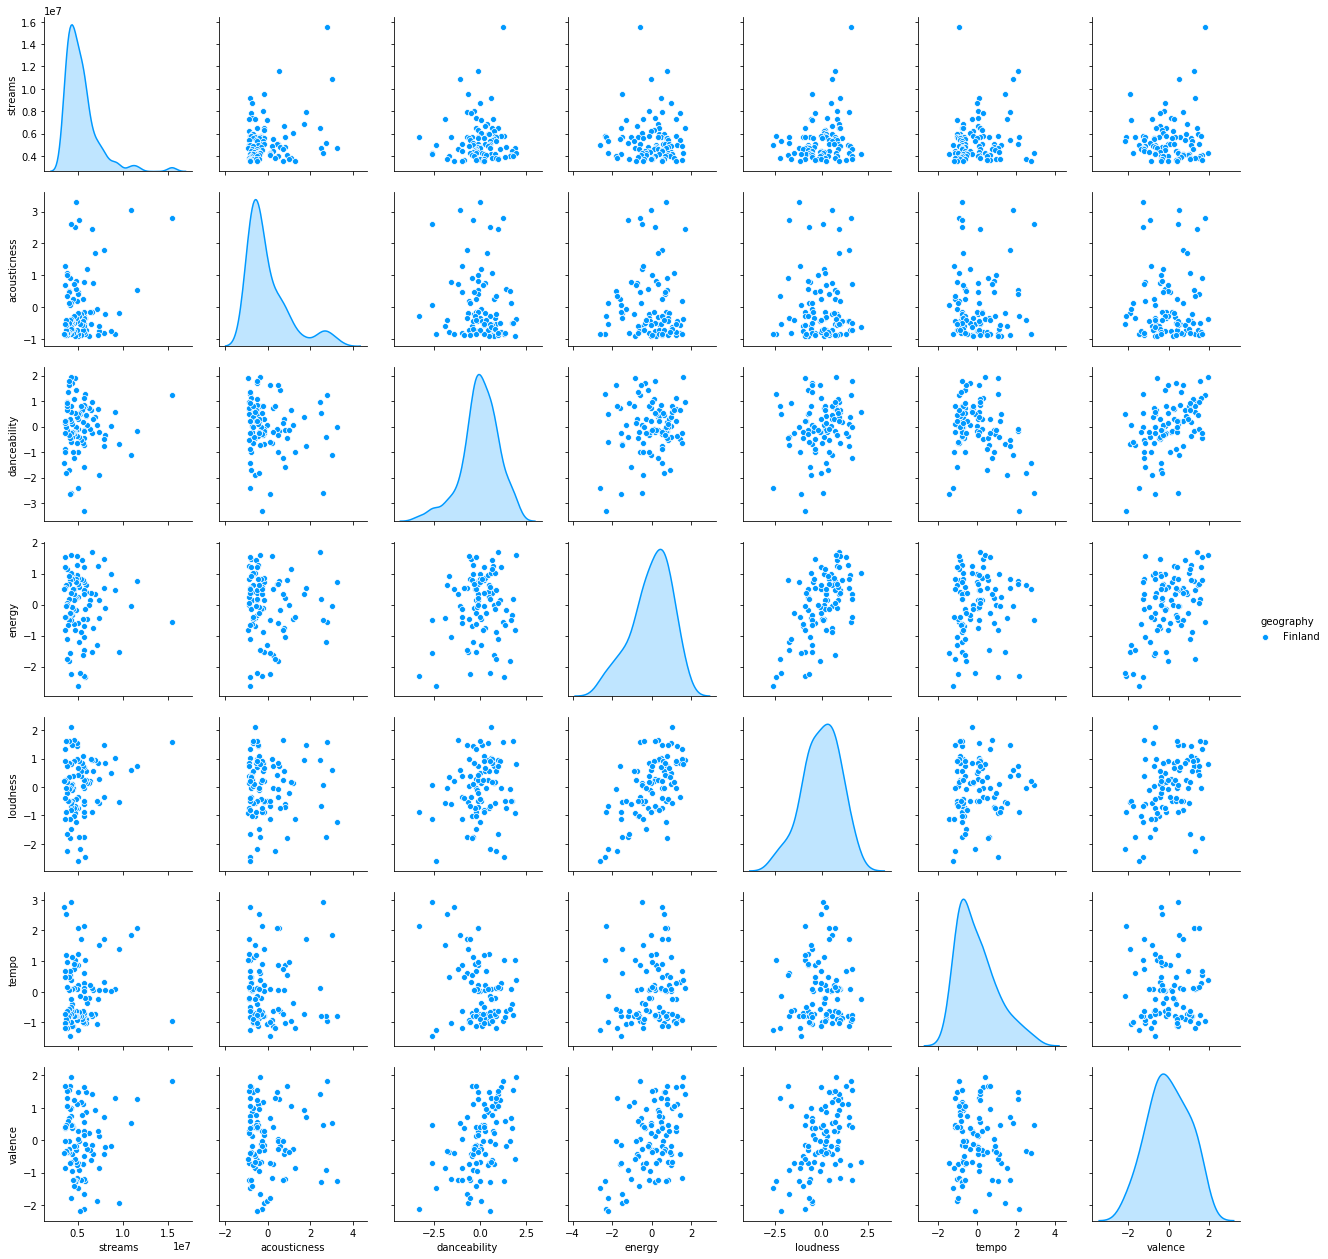

In [5]:
sns.pairplot(f2, palette=tri_palette[1::], hue=select)

### __Swedish data__

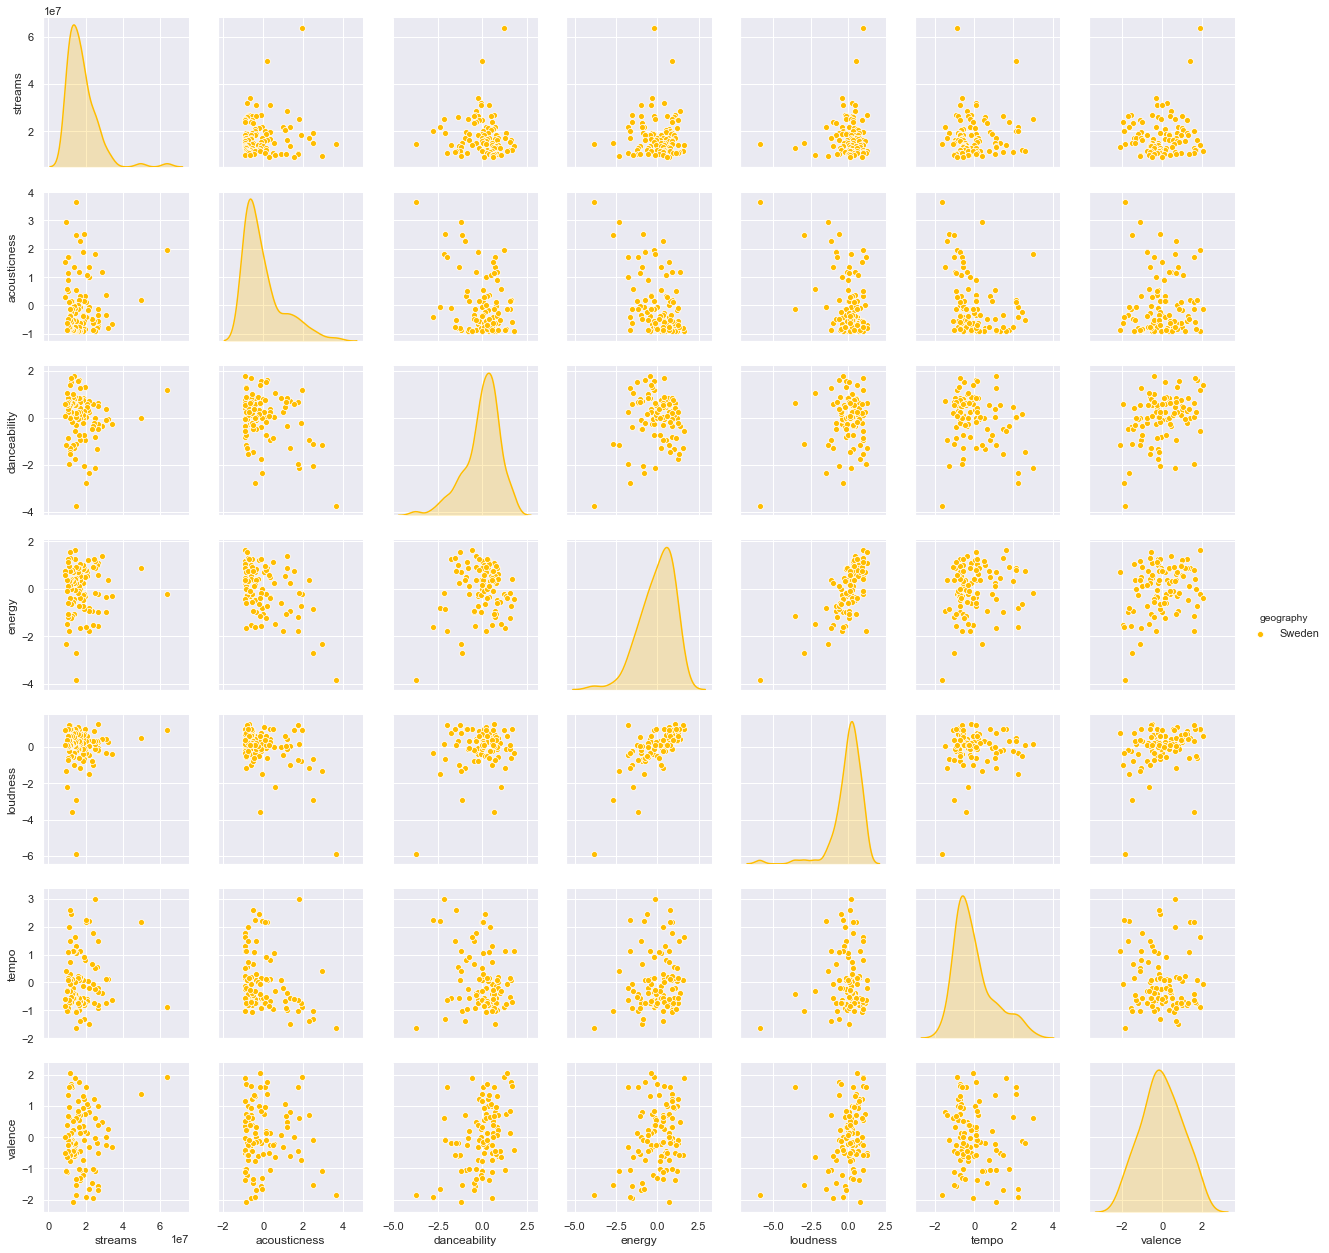

In [7]:
sns.pairplot(f3, palette=tri_palette[2::], hue=select)

### __Regression lines for individual features__
Finding least squares fits for streams ~ all other features.

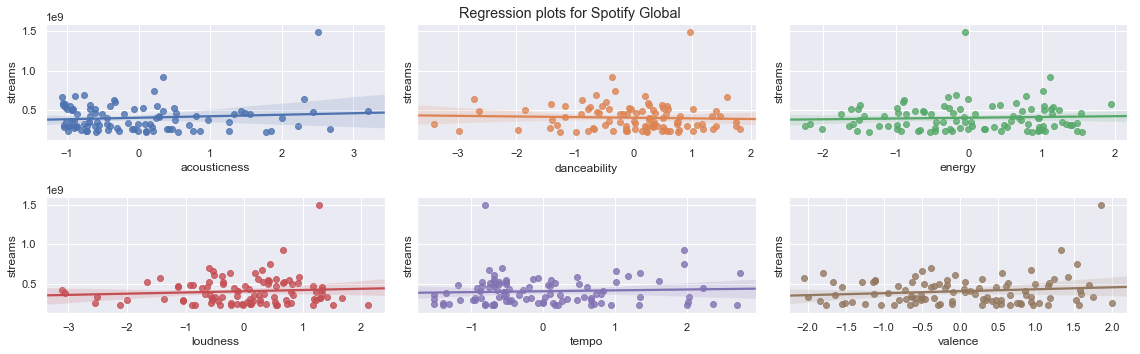

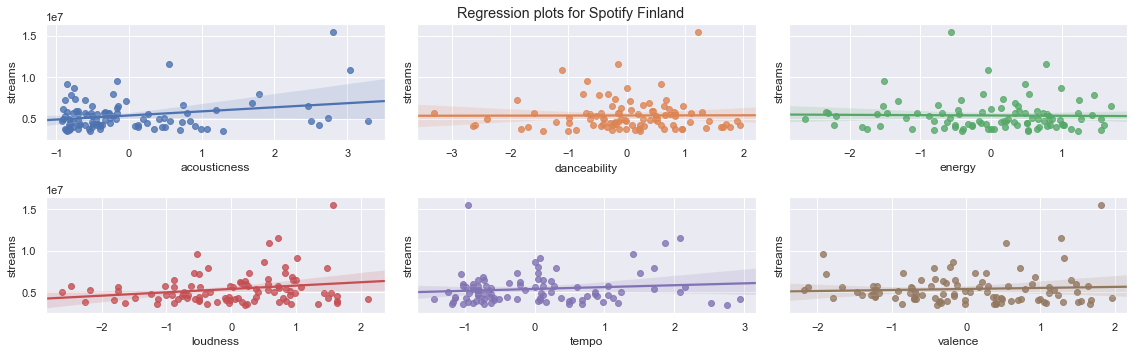

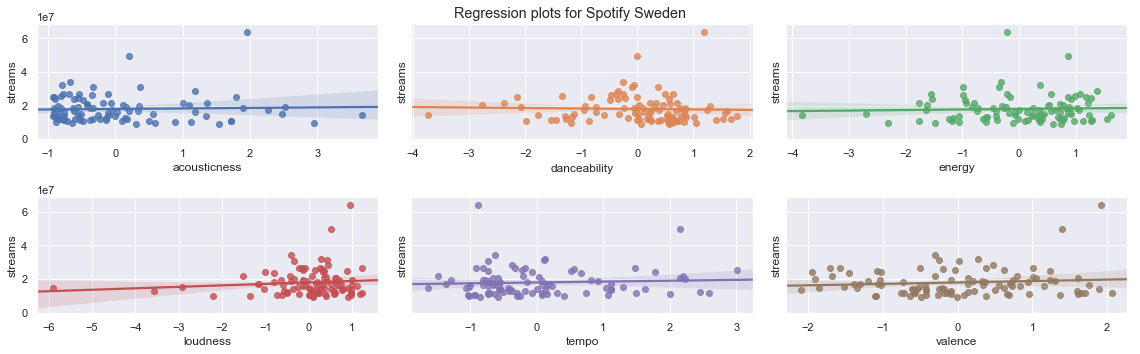

In [8]:
columns = list(global_data.columns)
columns.remove('streams')

for data,label in zip([global_data, finland_data, sweden_data],geo_labels):
    sns.set(rc={'figure.figsize':(16,5)})
    fig, axes = plt.subplots(2,3, sharey=True)
    fig.suptitle('Regression plots for Spotify {0}'.format(label))
    
    for col,ax in zip(columns, axes.flat):
        sns.regplot(data[col], data['streams'],ax=ax)
        
    fig.tight_layout()

### __Regression lines based on categorical valence__
Trying to observe more complex relationships we can observe three different covariates by grouping one of them into categories. Finding least squares fits for streams ~ other variables and grouping by valence which is turned into three categories: "negative", "neutral", "positive".

In [9]:
df_cat = global_data
df_cat['mood'] = 'neutral'
df_cat['mood'][df_cat['valence'] > 1] = 'positive'
df_cat['mood'][df_cat['valence'] < -1] = 'negative'

/home/mrreflex/anaconda3/envs/bdaproject/lib/python3.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/home/mrreflex/anaconda3/envs/bdaproject/lib/python3.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


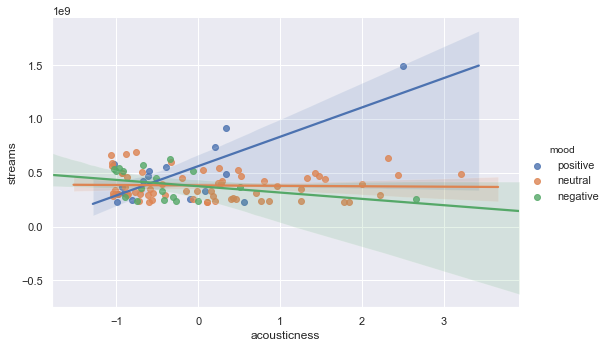

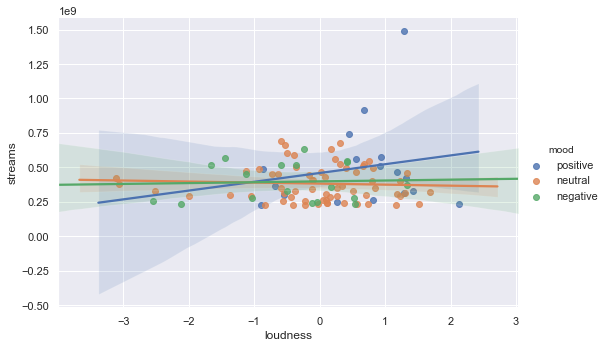

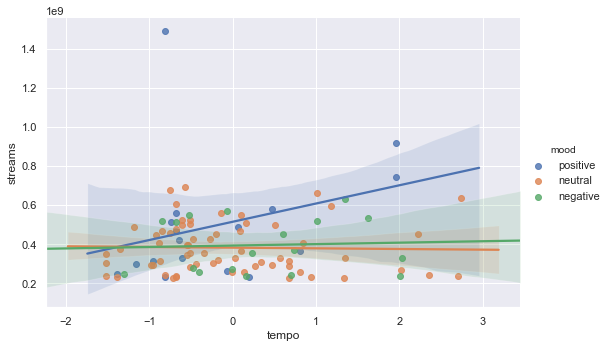

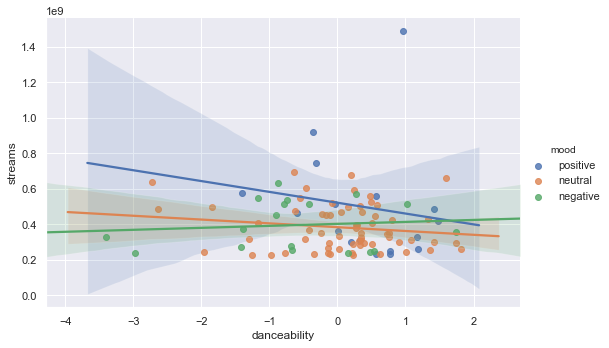

In [10]:
for i,col in enumerate(['acousticness', 'loudness', 'tempo', 'danceability']):
    sns.lmplot(x=col, y="streams", hue="mood", data=df_cat, aspect=1.5);

### __Data comparison by geography__
Let's begin by showing the overlayed pairplots for all three data sets. For this purpose we normalize the Streams count of global data by the number of countries in order to get comparable data.


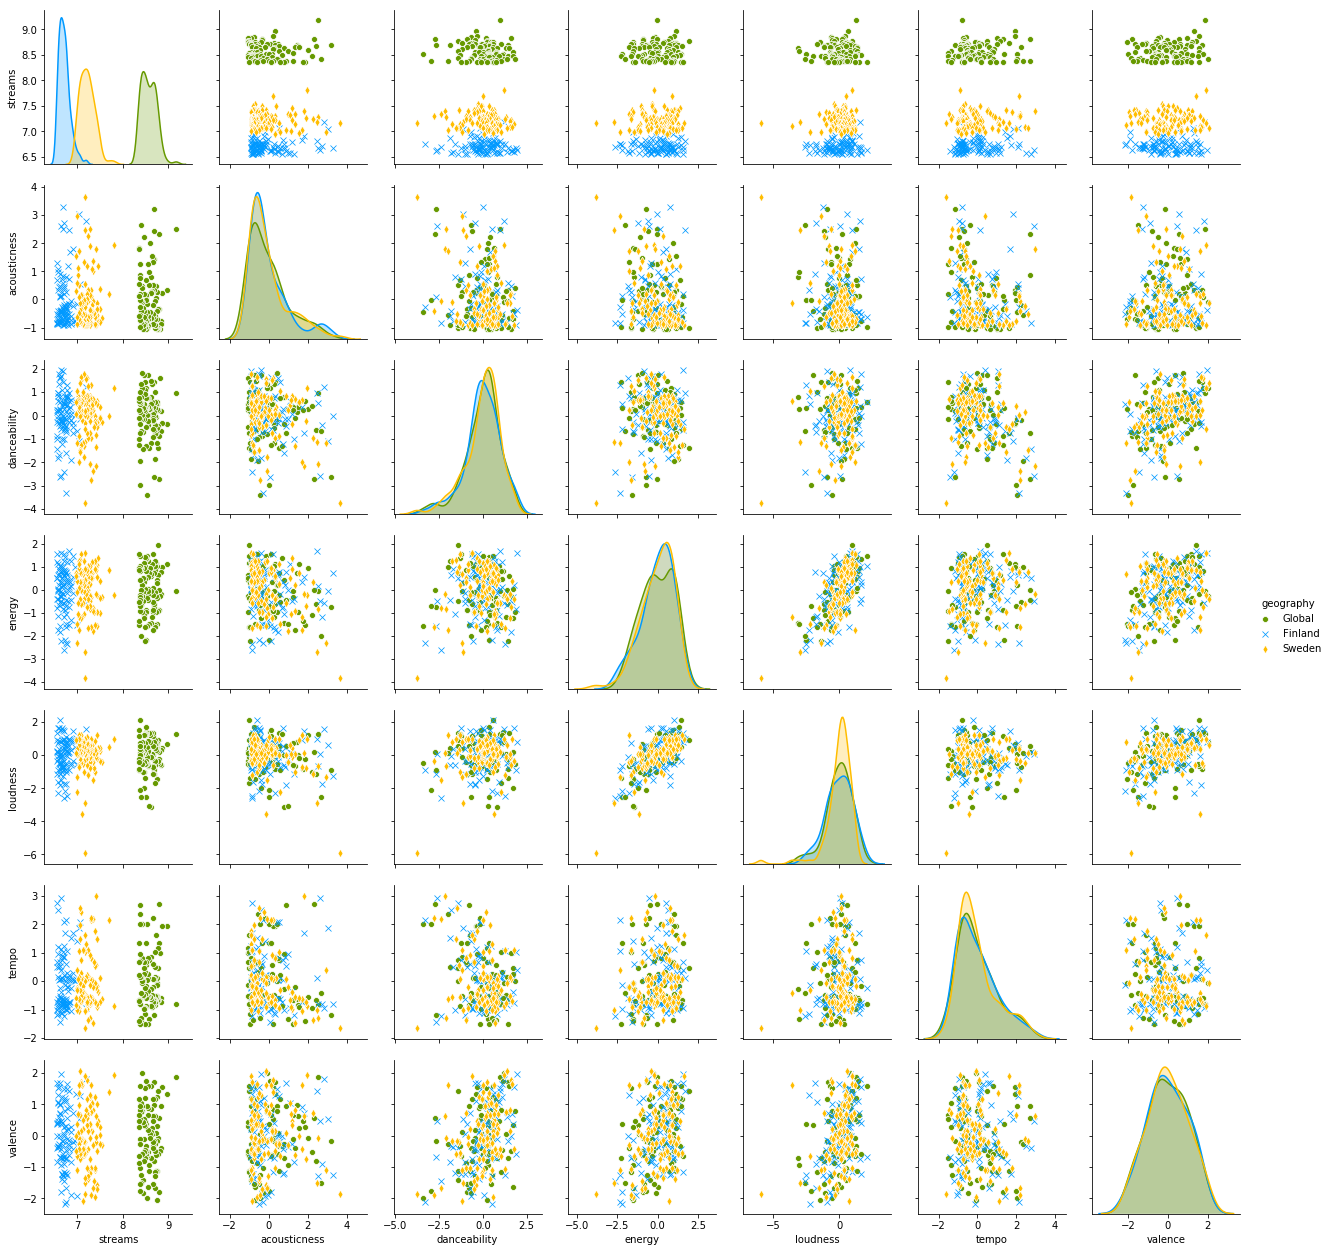

In [6]:
select = 'geography'
f1, f2, f3 = global_data, finland_data, sweden_data
f1[select], f2[select], f3[select] = geo_labels[0], geo_labels[1], geo_labels[2]
df = pd.concat([f1,f2,f3],axis=0)
df['streams'] = np.log10(df['streams'])

g = sns.pairplot(df, hue=select, diag_kind='kde', palette=tri_palette, markers=['o','x','d'])
 
for ax,col in zip(g.axes.flat, tri_palette): 
    plt.setp(ax.get_xticklabels(), rotation=45)    

## __Conclusions__ 

From pair distribution plots we can observe following points:
1. number of streams is long tail left skewed: most songs have less views with a few having a lot of views
2. none of the audio features appear to have really strong linear correlation with number of streams
3. energy and loudness are highly correlated, which is to be expected since [one of the determining factors of energy is loudness](https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/) 
4. there is some (although limited) amount of correlation between other pairs (for example `valence` and `loudness`)
5. `valence` and `energy` seem to be symmetrically distributed (normal), `energy` has two peaks (multimodal)

From heatmaps we can see that none of the single predictors have a strong correlation with the number of streams. However we can identify following weak co-correlation relationships (in descending order):

__Positive co-correlation__:
* Loudness ~ Energy (0.7)
* Valence ~ Loudness (0.4)
* Valence ~ Energy (0.3)
* Valence ~ Danceability (0.3)

__Negative co-correlation__:
* Danceability ~ Tempo (-0.4)
* Acousticness ~ Energy (-0.3)
* Acousticness ~ Loudness (-0.2)
* Tempo ~ Valence (-0.2)

__Distinctions in Swedish and Finnish data:__
There seems to be a stronger negative co-correlation in top-100 Swedish songs between Acousticness and Danceability whereas for Finnish music there is only negligible negative co-correlation for Acousticness with any of the other predictors.   